In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
from typing import List
import datasets
from datasets import concatenate_datasets

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain

from utils import *
sns.set_theme(rc={'figure.figsize': [14, 8]})

# Loading and Preprocessing

In [2]:
train_datasets = dict()
eval_datasets = dict()
predictions = dict()

In [3]:
train_datasets['default'], eval_datasets['default'] = get_split_dataset("data/en", seed=41)

Resolving data files:   0%|          | 0/433 [00:00<?, ?it/s]

Using custom data configuration default-60be5c4bd1ad25f6
Reusing dataset text (/home/alex/.cache/huggingface/datasets/text/default-60be5c4bd1ad25f6/0.0.0/acc32f2f2ef863c93c2f30c52f7df6cc9053a1c2230b8d7da0d210404683ca08)
Parameter 'function'=<function get_dataset.<locals>.attach_labels at 0x7fbb97a484c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/433 [00:00<?, ?ex/s]

In [4]:
# drop_classes = ['Capacity_and_resources', 'Economic', 'Public_opinion', 'Cultural_identity', 'Quality_of_life']
drop_classes = ['Capacity_and_resources', 'Economic', 'Public_opinion', 'Cultural_identity']
keep_classes = np.nonzero([int(c not in drop_classes) for c in categories])[0]
keep_classes

array([ 1,  4,  5,  6,  7,  8,  9, 10, 12, 13])

In [5]:
train_datasets['drop_labels'] = train_datasets['default'].map(lambda s: {'text': s['text'], 'labels': list(np.array(s['labels'])[keep_classes])})

  0%|          | 0/346 [00:00<?, ?ex/s]

In [6]:
def convert_drop_predictions(predictions, references):
    converted = np.zeros((len(references[0]), len(references)))
    converted[keep_classes] = predictions.T
    return converted.T

In [7]:
def load_economics_dataset(path:str, categories:List):
    data = pd.read_csv(path)
    labels = [int(c == 'Economic') for c in categories]
    data = pd.DataFrame({'text': data.headline + ' ' + data.text, 'labels': [labels for i in data.index]})
    return datasets.Dataset.from_pandas(data)

In [8]:
economics_dataset = load_economics_dataset('data/US-Economic-News.csv', categories)
economics_dataset = economics_dataset.train_test_split(0.1, seed=42)['test']
economics_dataset

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 63094: invalid start byte

In [9]:
train_datasets['economics'] = concatenate_datasets([train_datasets['default'], economics_dataset])
train_datasets['economics'].shuffle(seed=42)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1146
})

## Splitting

In [11]:
min_split_length = 5 * 250
num_splits = 8000 // min_split_length
def get_split(sample, min_split_length=min_split_length):
    """Adds new features of min length min_split_length to every sample."""
    new_sample = {'labels': sample['labels']}
    text = sample['text']
    split_nr = 0
    for i in range(num_splits):
        idx = text.find('.', min_split_length)+1
        if not idx:
            new_sample[f'split{split_nr}'] = ""
        else:
            new_sample[f'split{split_nr}'] = text[:idx].strip()
        text = text[idx:]
        split_nr += 1
    return new_sample

In [12]:
train_datasets['split_features'] = train_datasets['default'].map(get_split, remove_columns=train_datasets['default'].column_names)
train_datasets['split_features']

  0%|          | 0/346 [00:00<?, ?ex/s]

Dataset({
    features: ['labels', 'split0', 'split1', 'split2', 'split3', 'split4', 'split5'],
    num_rows: 346
})

In [13]:
eval_datasets['split_features'] = eval_datasets['default'].map(get_split, remove_columns=eval_datasets['default'].column_names)
eval_datasets['split_features']

  0%|          | 0/87 [00:00<?, ?ex/s]

Dataset({
    features: ['labels', 'split0', 'split1', 'split2', 'split3', 'split4', 'split5'],
    num_rows: 87
})

In [14]:
def get_split(samples, min_split_length=min_split_length):
    """Creates new samples of minimum length min_split_length with identical labels."""
    splits = list()
    labels = list()
    for text,label in zip(samples['text'], samples['labels']):
        while idx := text.find('.', min_split_length)+1:
            splits.append(text[:idx].strip())
            labels.append(label)
            text = text[idx:]
        if len(text) > 500:
            splits.append(text.strip())
            labels.append(label)
    return {'splits': splits, 'labels': labels}

In [15]:
train_datasets['split_samples'] = train_datasets['default'].map(get_split, batched=True, remove_columns=train_datasets['default'].column_names)
train_datasets['split_samples']

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['labels', 'splits'],
    num_rows: 1458
})

## Resampling

In [16]:
train_datasets['resampled'] = oversample(train_datasets['default'], 4)
print(f"Duplicated {train_datasets['resampled'].shape[0] - train_datasets['default'].shape[0]} samples.")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Duplicated 151 samples.


In [17]:
train_datasets['split_features_resampled'] = oversample(train_datasets['split_features'], 4)
print(f"Duplicated {train_datasets['split_features_resampled'].shape[0] - train_datasets['split_features'].shape[0]} samples.")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Duplicated 151 samples.


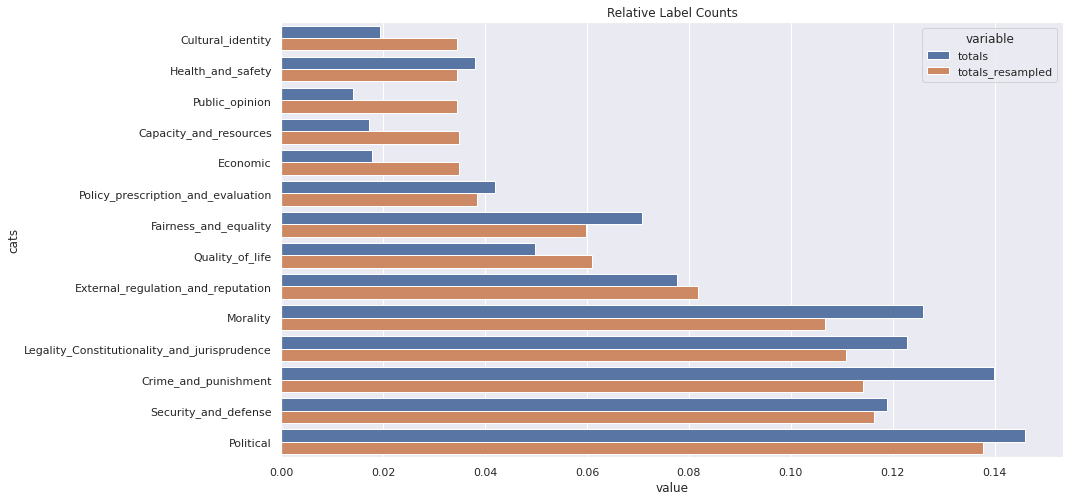

In [18]:
df_cats = pd.DataFrame({
    "cats": categories, 
    "totals": np.sum(train_datasets['default']["labels"], axis=0) / np.sum(train_datasets['default']["labels"]), 
    "totals_resampled": np.sum(train_datasets['resampled']["labels"], axis=0) / np.sum(train_datasets['resampled']["labels"])
})
df_cats = df_cats.sort_values(by="totals_resampled").melt(id_vars="cats")
sns.barplot(x="value", y="cats", hue="variable", data=df_cats).set_title('Relative Label Counts')
plt.show()

In [19]:
train_datasets

{'default': Dataset({
     features: ['text', 'labels'],
     num_rows: 346
 }),
 'drop_labels': Dataset({
     features: ['text', 'labels'],
     num_rows: 346
 }),
 'economics': Dataset({
     features: ['text', 'labels'],
     num_rows: 1146
 }),
 'split_features': Dataset({
     features: ['labels', 'split0', 'split1', 'split2', 'split3', 'split4', 'split5'],
     num_rows: 346
 }),
 'split_samples': Dataset({
     features: ['labels', 'splits'],
     num_rows: 1458
 }),
 'resampled': Dataset({
     features: ['text', 'labels'],
     num_rows: 497
 }),
 'split_features_resampled': Dataset({
     features: ['labels', 'split0', 'split1', 'split2', 'split3', 'split4', 'split5'],
     num_rows: 497
 })}

In [20]:
eval_datasets

{'default': Dataset({
     features: ['text', 'labels'],
     num_rows: 87
 }),
 'split_features': Dataset({
     features: ['labels', 'split0', 'split1', 'split2', 'split3', 'split4', 'split5'],
     num_rows: 87
 })}

# TfIdf

In [21]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('svc', OneVsRestClassifier(SVC()))
], verbose = True)
pipeline.fit(train_datasets['default']['text'], train_datasets['default']['labels'])
references = np.array(eval_datasets['default']['labels'])
predictions['tfidf_svc'] = pipeline.predict(eval_datasets['default']['text'])

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   5.3s


In [22]:
pipeline.fit(train_datasets['drop_labels']['text'], train_datasets['drop_labels']['labels'])
predictions['tfidf_svc_drop_labels'] = convert_drop_predictions(pipeline.predict(eval_datasets['default']['text']), references)

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   3.9s


In [23]:
pipeline.fit(train_datasets['economics']['text'], train_datasets['economics']['labels'])
predictions['tfidf_svc_economics'] = pipeline.predict(eval_datasets['default']['text'])

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing svc, total=  21.4s


In [24]:
pipeline.fit(train_datasets['split_samples']['splits'], train_datasets['split_samples']['labels'])
predictions['tfidf_svc_split_samples'] = pipeline.predict(eval_datasets['default']['text'])

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing svc, total=  35.7s


In [25]:
pipeline.fit(train_datasets['resampled']['text'], train_datasets['resampled']['labels'])
predictions['tfidf_svc_resampled'] = pipeline.predict(eval_datasets['default']['text'])

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   8.3s


In [29]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_datasets['resampled']['text'])
X_eval = tfidf_vectorizer.transform(eval_datasets['default']['text'])

In [30]:
custom_chain = ClassifierChain(SVC(), order=np.argsort(np.sum(train_datasets['default']['labels'], axis=0))[::-1])
custom_chain.fit(X_train, train_datasets['resampled']['labels'])
#chain_predictions['custom_chain'] = custom_chain.predict(X_eval)
chain_predictions = {'custom_chain': custom_chain.predict(X_eval)}

In [31]:
calculate_f1_scores(chain_predictions, references)

,Method,MicroF1,MacroF1
0,custom_chain,0.678201,0.431065


# Transformers

In [33]:
from sentence_transformers import SentenceTransformer
from sklearn.neural_network import MLPClassifier

In [34]:
train_embeddings = dict()
eval_embeddings = dict()

In [35]:
model = SentenceTransformer('all-mpnet-base-v2')
train_embeddings['default_mpnet_base'] = model.encode(train_datasets['default']['text'])
eval_embeddings['default_mpnet_base'] = model.encode(eval_datasets['default']['text'])

/home/alex/.pyenv/versions/3.9.0/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() > 0


In [47]:
model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings['default'] = model.encode(train_datasets['default']['text'])
eval_embeddings['default'] = model.encode(eval_datasets['default']['text'])

In [39]:
train_embeddings['resampled'] = model.encode(train_datasets['resampled']['text'])

In [40]:
train_embeddings['split_samples'] = model.encode(train_datasets['split_samples']['splits'])

In [36]:
classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', OneVsRestClassifier(SVC()))
], verbose=True)

In [50]:
classifier.fit(train_embeddings['default_all'], train_datasets['default_all']['labels'])
predictions['minilm_svc_all'] = classifier.predict(eval_embeddings['default'])

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   0.5s


In [44]:
classifier.fit(train_embeddings['default'], train_datasets['default']['labels'])
predictions['minilm_svc'] = classifier.predict(eval_embeddings['default'])

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   0.2s


In [45]:
classifier.fit(train_embeddings['resampled'], train_datasets['resampled']['labels'])
predictions['minilm_svc_resampled'] = classifier.predict(eval_embeddings['default'])

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   0.3s


In [46]:
classifier.fit(train_embeddings['split_samples'], train_datasets['split_samples']['labels'])
predictions['minilm_svc_split_samples'] = classifier.predict(eval_embeddings['default'])

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   8.3s


In [38]:
classifier.fit(train_embeddings['default_mpnet_base'], train_datasets['default']['labels'])
predictions['mpnet_svc'] = classifier.predict(eval_embeddings['default_mpnet_base'])

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   0.4s


In [39]:
custom_chain.fit(train_embeddings['default_mpnet_base'], train_datasets['default']['labels'])
predictions['mpnet_svc_chain'] = custom_chain.predict(eval_embeddings['default_mpnet_base'])

## Torch

In [41]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Sampler
from torchmetrics.classification import MultilabelF1Score
from typing import List, Iterator

from custom_classes.custom_sampler import ContrastSampler

/home/alex/.pyenv/versions/3.9.0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [42]:
class Trainer:
    def __init__(self, model, loader, eval_loader, criterion, optimizer, n_classes, n_train_classes=None, convert_predictions=None):
        self.model = model
        self.loader = loader
        self.eval_loader = eval_loader
        self.criterion = criterion
        self.optimizer = optimizer
        if not n_train_classes:
            n_train_classes = n_classes
        self.metrics = {
            'macro': MultilabelF1Score(num_labels=n_classes, average='macro'),
            'micro': MultilabelF1Score(num_labels=n_classes, average='micro'),
            'train_macro': MultilabelF1Score(num_labels=n_train_classes, average='macro'),
            'train_micro': MultilabelF1Score(num_labels=n_train_classes, average='micro'),
        }
        self.convert_predictions = convert_predictions
        
    def train(self, n_epochs):
        epoch_losses = list()
        microf1 = list()
        macrof1 = list()
        train_microf1 = list()
        train_macrof1 = list()
        for i in range(100):
            losses = list()
            torch.set_grad_enabled(True)
            self.model.train()
            for batch in self.loader:
                embeddings, labels = batch
                prediction_probs = self.model(embeddings)
                loss = self.criterion(prediction_probs, labels)
                losses.append(loss.detach())
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            self.model.eval()
            torch.set_grad_enabled(False)
            preds = list()
            labels = list()
            for batch in self.eval_loader:
                embeddings, ls = batch
                preds.append(torch.round(torch.sigmoid(self.model(embeddings))))
                labels.append(ls)
            preds = torch.cat(preds)
            labels = torch.cat(labels)
            if self.convert_predictions:
                preds = torch.tensor(self.convert_predictions(preds.numpy(), labels.numpy()))
            microf1.append(self.metrics['micro'](preds, labels).numpy())
            macrof1.append(self.metrics['macro'](preds, labels).numpy())
            preds = list()
            labels = list()
            for batch in loader:
                embeddings, ls = batch
                preds.append(torch.round(torch.sigmoid(self.model(embeddings))))
                labels.append(ls)
            preds = torch.cat(preds)
            labels = torch.cat(labels)
            train_microf1.append(self.metrics['train_micro'](preds, labels).numpy())
            train_macrof1.append(self.metrics['train_macro'](preds, labels).numpy())

            epoch_losses.append(np.mean(losses))
        return epoch_losses, microf1, macrof1, train_microf1, train_macrof1

In [43]:
def plot_torch_metrics(losses, microf1, macrof1, train_microf1, train_macrof1):
    fig, ax = plt.subplots()
    loss = ax.plot(losses, label='Loss')
    ax2 = ax.twinx()
    m1 = ax2.plot(microf1, c='red', label='MicroF1')
    m2 = ax2.plot(macrof1, c='orange', label='MacroF1')
    m3 = ax2.plot(train_microf1, c='red', label='Train MicroF1', linestyle='dotted')
    m4 = ax2.plot(train_macrof1, c='orange', label='Train MacroF1', linestyle='dotted')
    ax2.axhline(np.max(microf1), c='red', linestyle='dashed')
    ax2.axhline(np.max(macrof1), c='orange', linestyle='dashed')
    lns = loss+m1+m2+m3+m4
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs)
    plt.show()
    argmax_microf1 = np.argmax(microf1)
    print("MicroF1: ", microf1[argmax_microf1], " @ ", argmax_microf1)
    print("MacroF1: ", np.max(macrof1), " @ ", np.argmax(macrof1))
    print("MacroF1: ", macrof1[argmax_microf1], " @ ", argmax_microf1)

In [48]:
criterion = nn.BCEWithLogitsLoss()
torch_datasets = dict()
torch_eval_datasets = dict()
torch_datasets['default'] = TensorDataset(torch.tensor(train_embeddings['default']), torch.tensor(train_datasets['default']['labels'], dtype=torch.float32))
#torch_datasets['drop_labels'] = TensorDataset(torch.tensor(train_embeddings['default']), torch.tensor(train_datasets['drop_labels']['labels'], dtype=torch.float32))
torch_eval_datasets['default'] = TensorDataset(torch.tensor(eval_embeddings['default']), torch.tensor(eval_datasets['default']['labels'], dtype=torch.float32))
#torch_datasets['resampled'] = TensorDataset(torch.tensor(train_embeddings['resampled']), torch.tensor(train_datasets['resampled']['labels'], dtype=torch.float32))
#torch_datasets['split_samples'] = TensorDataset(torch.tensor(train_embeddings['split_samples']), torch.tensor(train_datasets['split_samples']['labels'], dtype=torch.float32))

#torch_datasets['drop_labels_mpnet'] = TensorDataset(torch.tensor(train_embeddings['default_mpnet_base']), torch.tensor(train_datasets['drop_labels']['labels'], dtype=torch.float32))
torch_datasets['default_mpnet_base'] = TensorDataset(torch.tensor(train_embeddings['default_mpnet_base']), torch.tensor(train_datasets['default']['labels'], dtype=torch.float32))
torch_eval_datasets['default_mpnet_base'] = TensorDataset(torch.tensor(eval_embeddings['default_mpnet_base']), torch.tensor(eval_datasets['default']['labels'], dtype=torch.float32))

torch_datasets.keys()

dict_keys(['default', 'default_mpnet_base'])

### MiniLM Embedding Default

In [49]:
n_classes = len(train_datasets['default']['labels'][0])
torch_model = nn.Sequential(
    nn.Linear(384, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, n_classes),
    nn.Dropout(),
)
optimizer = torch.optim.AdamW(torch_model.parameters())
train_sampler = ContrastSampler(torch_datasets['default'], 1, 50)
loader = DataLoader(torch_datasets['default'], batch_sampler=train_sampler)
eval_loader = DataLoader(torch_eval_datasets['default'], batch_size=1000)

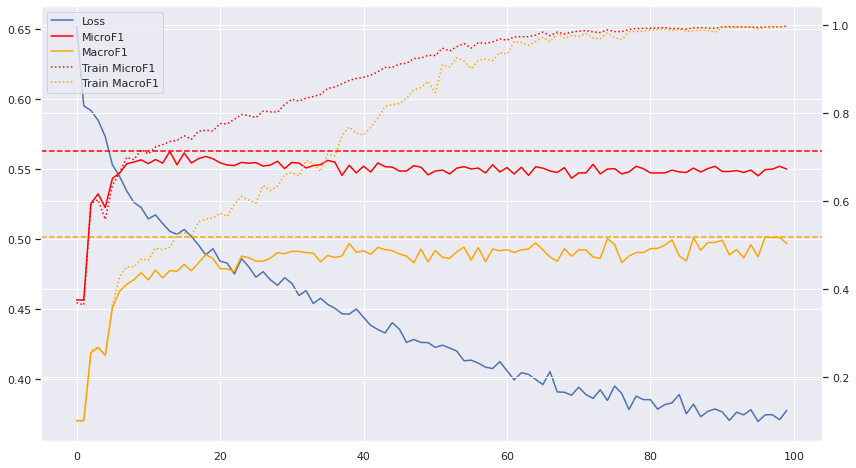

MicroF1:  0.7121464  @  13
MacroF1:  0.51794744  @  96
MacroF1:  0.4412659  @  13


In [50]:
trainer = Trainer(torch_model, loader, eval_loader, criterion, optimizer, n_classes)
epoch_losses, microf1, macrof1, train_microf1, train_macrof1 = trainer.train(100)
plot_torch_metrics(epoch_losses, microf1, macrof1, train_microf1, train_macrof1)

### MiniLM Embedding Resampled

In [101]:
n_classes = len(train_datasets['resampled']['labels'][0])
torch_model = nn.Sequential(
    nn.Linear(384, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, n_classes),
    nn.Dropout(),
)
optimizer = torch.optim.AdamW(torch_model.parameters())
train_sampler = ContrastSampler(torch_datasets['resampled'], 1, 50)
loader = DataLoader(torch_datasets['resampled'], batch_sampler=train_sampler)
eval_loader = DataLoader(torch_eval_datasets['default'], batch_size=1000)

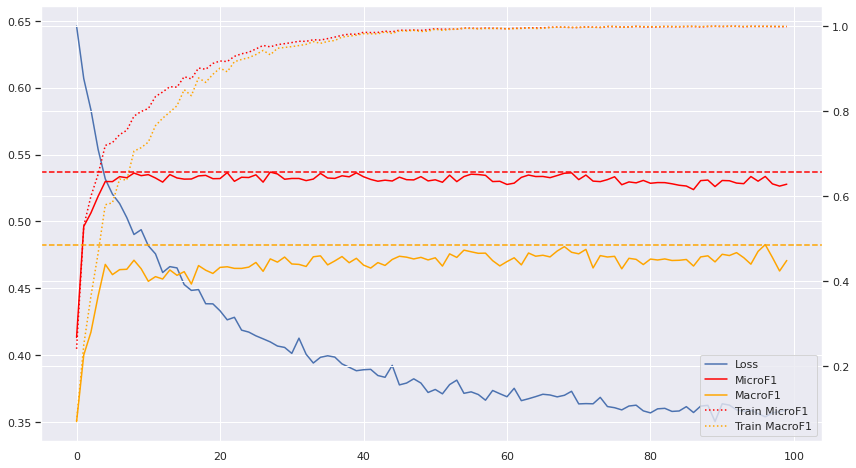

MicroF1:  0.65656567  @  27
MacroF1:  0.48601806  @  96
MacroF1:  0.45249882  @  27


In [102]:
trainer = Trainer(torch_model, loader, eval_loader, criterion, optimizer, n_classes)
epoch_losses, microf1, macrof1, train_microf1, train_macrof1 = trainer.train(100)
plot_torch_metrics(epoch_losses, microf1, macrof1, train_microf1, train_macrof1)

### MiniLM Embedding Split Samples

In [103]:
n_classes = len(train_datasets['split_samples']['labels'][0])
torch_model = nn.Sequential(
    nn.Linear(384, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, n_classes),
    nn.Dropout(),
)
optimizer = torch.optim.AdamW(torch_model.parameters())
train_sampler = ContrastSampler(torch_datasets['split_samples'], 1, 50)
loader = DataLoader(torch_datasets['split_samples'], batch_sampler=train_sampler)
eval_loader = DataLoader(torch_eval_datasets['default'], batch_size=1000)

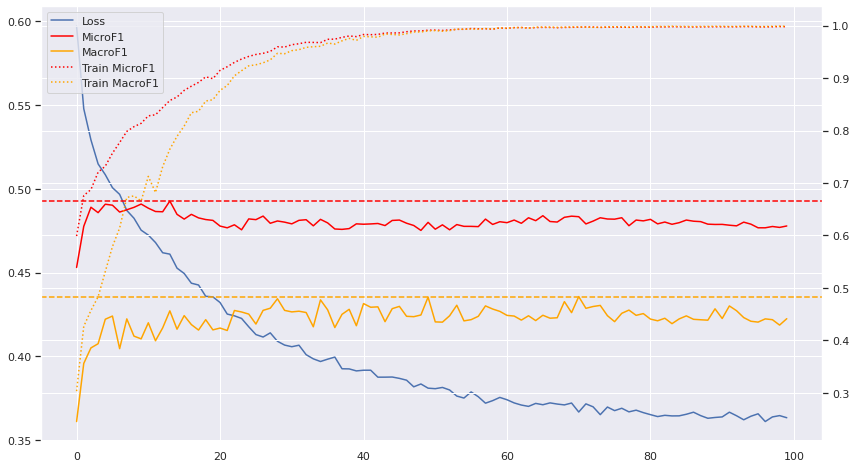

MicroF1:  0.6655629  @  13
MacroF1:  0.4835103  @  70
MacroF1:  0.4564173  @  13


In [104]:
trainer = Trainer(torch_model, loader, eval_loader, criterion, optimizer, n_classes)
epoch_losses, microf1, macrof1, train_microf1, train_macrof1 = trainer.train(100)
plot_torch_metrics(epoch_losses, microf1, macrof1, train_microf1, train_macrof1)

### MiniLM Embedding Drop Labels

In [171]:
n_classes = len(train_datasets['drop_labels']['labels'][0])
torch_model = nn.Sequential(
    nn.Linear(384, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, n_classes),
    nn.Dropout(),
)
optimizer = torch.optim.AdamW(torch_model.parameters())
train_sampler = ContrastSampler(torch_datasets['drop_labels'], 1, 50)
loader = DataLoader(torch_datasets['drop_labels'], batch_sampler=train_sampler)
eval_loader = DataLoader(torch_eval_datasets['default'], batch_size=1000)

/home/alex/Uni/Thesis/semeval2023task3/custom_classes/custom_sampler.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._labels = torch.tensor(data_source.tensors[labels_idx].clone().detach()).t()


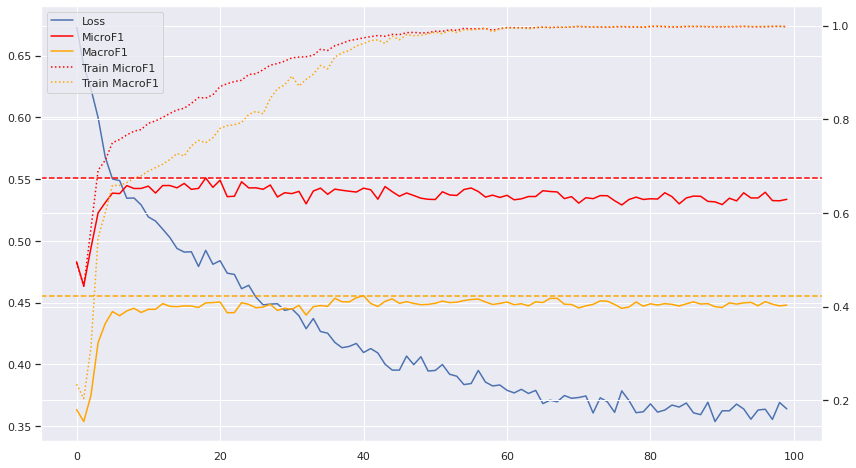

MicroF1:  0.6748252  @  18
MacroF1:  0.42331082  @  40
MacroF1:  0.40793675  @  18


In [172]:
trainer = Trainer(torch_model, loader, eval_loader, criterion, optimizer, n_classes=14, n_train_classes=n_classes, convert_predictions=convert_drop_predictions)
epoch_losses, microf1, macrof1, train_microf1, train_macrof1 = trainer.train(100)
plot_torch_metrics(epoch_losses, microf1, macrof1, train_microf1, train_macrof1)

### MPNET Embedding Default

In [45]:
n_classes = len(train_datasets['default']['labels'][0])
torch_model = nn.Sequential(
    nn.Linear(768, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, n_classes),
    nn.Dropout(),
)
optimizer = torch.optim.AdamW(torch_model.parameters())
train_sampler = ContrastSampler(torch_datasets['default_mpnet_base'], 1, 50)
loader = DataLoader(torch_datasets['default_mpnet_base'], batch_sampler=train_sampler)
eval_loader = DataLoader(torch_eval_datasets['default_mpnet_base'], batch_size=1000)

/home/alex/Uni/Thesis/semeval2023task3/custom_classes/custom_sampler.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._labels = torch.tensor(data_source.tensors[labels_idx].clone().detach()).t()


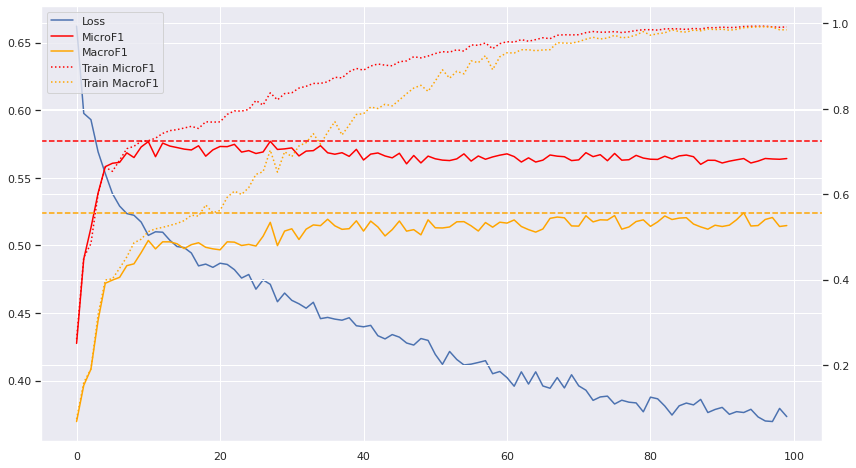

MicroF1:  0.72374797  @  27
MacroF1:  0.5564863  @  93
MacroF1:  0.5340847  @  27


In [46]:
trainer = Trainer(torch_model, loader, eval_loader, criterion, optimizer, n_classes)
epoch_losses, microf1, macrof1, train_microf1, train_macrof1 = trainer.train(100)
plot_torch_metrics(epoch_losses, microf1, macrof1, train_microf1, train_macrof1)

### MPNET Embedding Drop Labels

In [71]:
n_classes = len(train_datasets['drop_labels']['labels'][0])
torch_model = nn.Sequential(
    nn.Linear(768, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(512, n_classes),
    nn.Dropout(),
)
optimizer = torch.optim.AdamW(torch_model.parameters())
train_sampler = ContrastSampler(torch_datasets['drop_labels_mpnet'], 1, 50)
loader = DataLoader(torch_datasets['drop_labels_mpnet'], batch_sampler=train_sampler)
eval_loader = DataLoader(torch_eval_datasets['default_mpnet_base'], batch_size=1000)

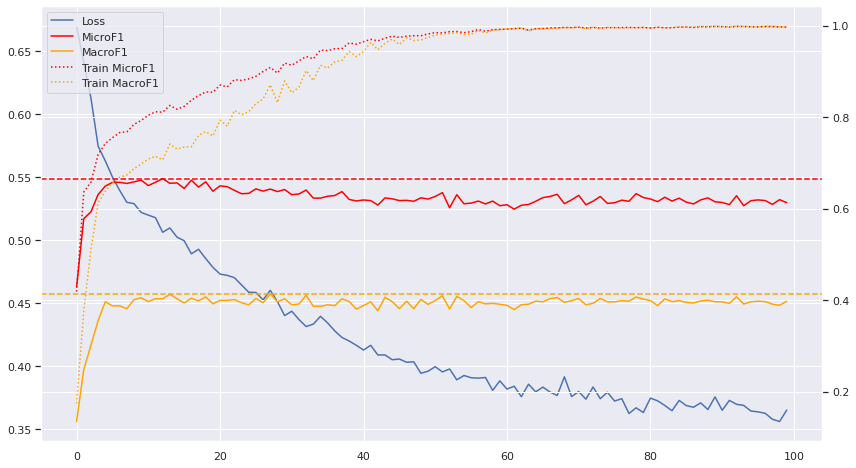

MicroF1:  0.66549915  @  12
MacroF1:  0.41382328  @  27
MacroF1:  0.40278944  @  12


In [72]:
trainer = Trainer(torch_model, loader, eval_loader, criterion, optimizer, n_classes=14, n_train_classes=n_classes, convert_predictions=convert_drop_predictions)
epoch_losses, microf1, macrof1, train_microf1, train_macrof1 = trainer.train(100)
plot_torch_metrics(epoch_losses, microf1, macrof1, train_microf1, train_macrof1)

## Voting

In [59]:
def get_split_embeddings(sample):
    new_sample = {'labels': sample['labels']}
    for i in range(num_splits):
        key = f'split{i}'
        new_sample[key] = model.encode(sample[key])
    return new_sample
train_embeddings['split_features250'] = train_datasets['split_features'].map(get_split_embeddings, remove_columns=train_datasets['split_features'].column_names)
eval_embeddings['split_features250'] = eval_datasets['split_features'].map(get_split_embeddings, remove_columns=eval_datasets['split_features'].column_names)

  0%|          | 0/346 [00:00<?, ?ex/s]

  0%|          | 0/87 [00:00<?, ?ex/s]

In [60]:
def train_and_predict_splits(train_dataset, eval_dataset, classifier, references):
    split_keys = [f'split{i}' for i in range(num_splits)]
    predictions = list()
    train_predictions = list()
    for i,key in enumerate(split_keys):
        print(f"Training on split {i+1}/{num_splits}\r", end="")
        classifier.fit(train_dataset[key], train_dataset["labels"])
        train_predictions.append(classifier.predict_proba(train_dataset[key]))
        predictions.append(classifier.predict_proba(eval_dataset[key]))
    return np.array(train_predictions), np.array(predictions)

In [61]:
classifier = Pipeline([
    #('scaler', StandardScaler()),
    #('svc', OneVsRestClassifier(SVC(probability=True))),
    ('lr_chain', ClassifierChain(LogisticRegression(), order=np.argsort(np.sum(train_datasets['default']["labels"], axis=0))[::-1])),
    #('lr', OneVsRestClassifier(LogisticRegression(class_weight='balanced'))),
])
train_split_predictions, eval_split_predictions = train_and_predict_splits(train_embeddings['split_features250'], eval_embeddings['split_features250'], classifier, references)

In [62]:
train_split_predictions[:-5].shape

(1, 346, 14)

In [64]:
classifier = Pipeline([
    #('scaler', StandardScaler()),
    ('svc', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
])
classifier.fit(np.moveaxis(train_split_predictions[:], 0, 1).reshape(len(train_datasets['split_features']), -1), train_datasets['split_features']['labels'])
predictions['minilm_lr_chain_splits_proba'] = classifier.predict(np.moveaxis(eval_split_predictions[:], 0, 1).reshape(len(eval_datasets['split_features']), -1))
#predictions['minilm_lr_splits_proba_balanced'] = classifier.predict(np.moveaxis(eval_split_predictions[:], 0, 1).reshape(len(eval_datasets_split), -1))

# Analysis

In [65]:
calculate_f1_scores(predictions, references)

,Method,MicroF1,MacroF1
5,mpnet_svc,0.705281,0.452407
7,minilm_lr_chain_splits_proba,0.699659,0.457345
6,mpnet_svc_chain,0.687609,0.427099
4,tfidf_svc_resampled,0.686620,0.453399
0,tfidf_svc,0.679715,0.403498
1,tfidf_svc_drop_labels,0.679715,0.403498
3,tfidf_svc_split_samples,0.678024,0.432197
2,tfidf_svc_economics,0.624521,0.377541


In [96]:
calculate_f1_scores(predictions, references)

,Method,MicroF1,MacroF1
4,tfidf_svc_resampled,0.663102,0.453229
8,minilm_svc_split_samples,0.662139,0.451302
5,minilm_svc,0.661871,0.393167
3,tfidf_svc_split_samples,0.658940,0.458318
7,minilm_svc_resampled,0.658407,0.400275
0,tfidf_svc,0.653430,0.387152
1,tfidf_svc_drop_labels,0.653430,0.387152
9,minilm_lr_chain_splits_proba,0.652482,0.418521
2,tfidf_svc_economics,0.615686,0.399139
6,minilm_svc_all,0.276596,0.096864


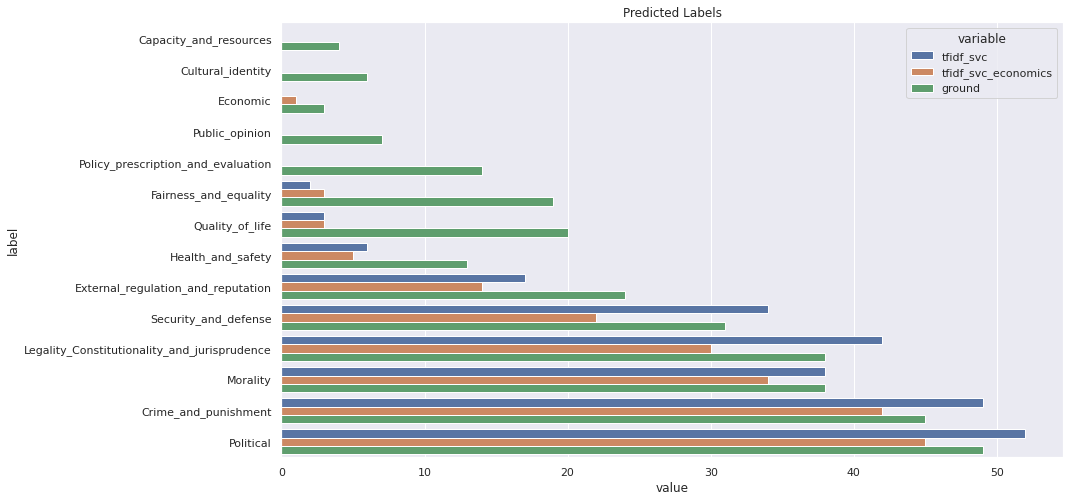

In [173]:
plot_predicted_label_counts(predictions, references, ['tfidf_svc', 'tfidf_svc_economics'])

f1: [0.         0.71264368 0.         0.5        0.63157895 0.18181818
 0.55555556 0.61764706 0.72222222 0.         0.85106383 0.
 0.17391304 0.64150943]
micro-f1: 0.615686274509804
macro-f1: 0.3991394250840421


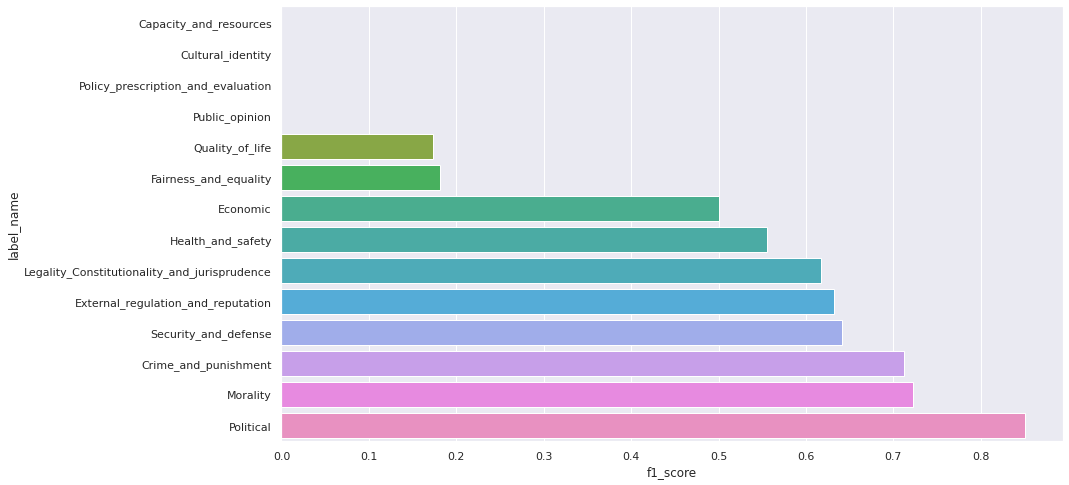

In [174]:
per_label_f1(predictions['tfidf_svc_economics'], references)
plt.show()

f1: [0.         0.74468085 0.28571429 0.4        0.76190476 0.27272727
 0.63157895 0.69135802 0.72       0.13333333 0.89108911 0.
 0.16666667 0.64615385]
micro-f1: 0.6631016042780749
macro-f1: 0.45322907846676197


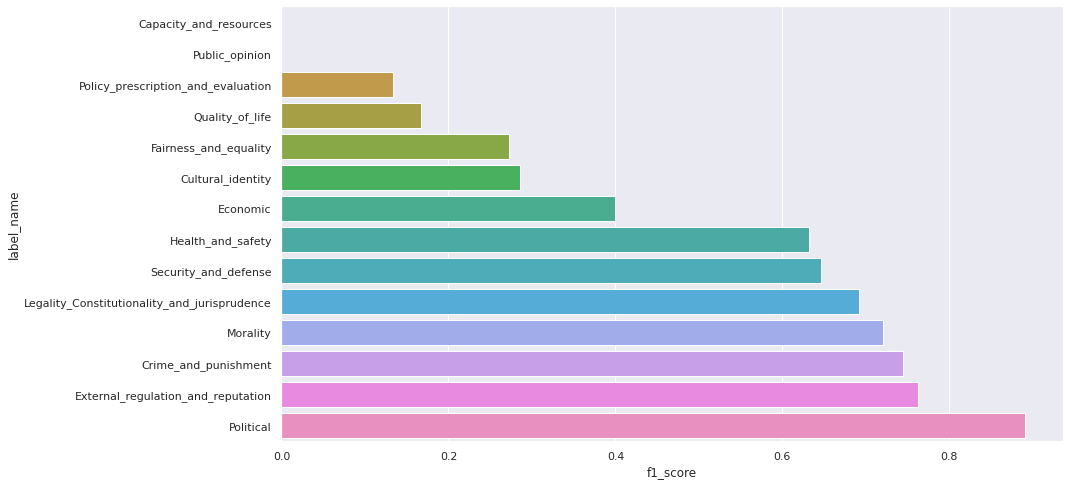

In [31]:
per_label_f1(predictions['tfidf_svc_resampled'], references)
plt.show()

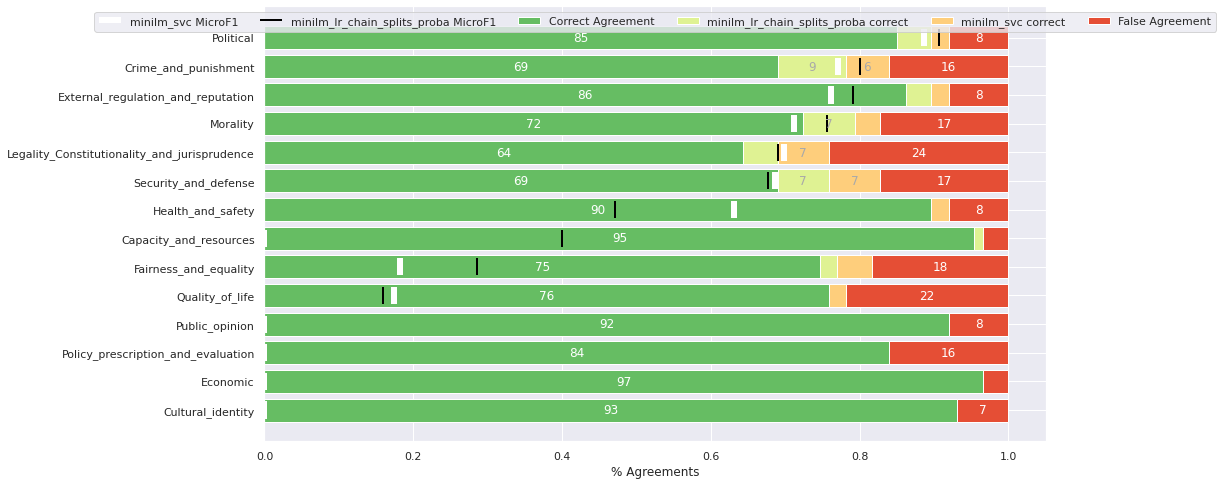

In [34]:
model1, model2 = 'minilm_lr_chain_splits_proba', 'minilm_svc'
agreements = calculate_agreements(predictions, references, model1, model2)
order = agreements.sort_values(by=[f'{model1} MicroF1', f'{model2} MicroF1'], ascending=True).index
ordered_labels = (np.array(train_dataset['labels'])).T[order].T
plot_agreements(agreements.iloc[order], ordered_labels)